In [1]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

'''
GPU 사용 선언
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
랜덤시드 고정
'''
torch.manual_seed(777)

'''
하이퍼파라미터 선언
'''
sequence_length = 12 # 271년의 데이터
input_size = 2 # 1개의 sequence의 내부에 1개의 데이터
hidden_size = 32
output_size = 1
num_layers = 4
learning_rate = 1e-4
nb_epochs = 500

'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/Sunspots.csv', header = 0, parse_dates = [0], index_col = 0, squeeze = True)
original_data_df = original_data_df.reset_index(drop = True)
print(original_data_df.shape)

'''
데이터프레임 컬럼 이름 변경
'''
original_data_df.columns = ['Month', 'Sunspot num']
print(original_data_df.head())

'''
날짜 하이픈 제거
'''
original_data_df['Month'] = original_data_df['Month'].str.replace(pat=r'[^\w\s]', repl=r'', regex=True) # 하이픈제거
original_data_df = original_data_df.astype('int')

(3252, 2)
        Month  Sunspot num
0  1749-01-31         96.7
1  1749-02-28        104.3
2  1749-03-31        116.7
3  1749-04-30         92.8
4  1749-05-31        141.7


In [2]:
'''
train, test data 분리
'''
train_size = int(len(original_data_df) * 0.7)
train_set = original_data_df[0:train_size]
test_set = original_data_df[train_size - sequence_length:]

'''
스케일링함수 선언
'''
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

'''
데이터셋 함수 선언
'''
def build_data(time_series, sequence_length):
    x_data = []
    y_data = []

    for i in range(0, len(time_series) - sequence_length):
        _x = time_series.values[i: i + sequence_length, :]
        _y = time_series.values[i + sequence_length, [-1]]
        x_data.append(_x)
        y_data.append(_y)

    return np.array(x_data), np.array(y_data)

'''
데이터로더 함수 선언
'''
def MakeDataLoader(x_np, y_np):
    '''
    totensor
    '''
    x_ts = torch.FloatTensor(x_np)
    y_ts = torch.FloatTensor(y_np)

    '''
    dataset & dataloader
    '''
    dataset = TensorDataset(x_ts, y_ts)
    dataloader = DataLoader(dataset, batch_size = sequence_length, shuffle = True)

    return dataloader

In [3]:
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)
x_train_np, y_train_np = build_data(train_set, sequence_length)
x_test_np, y_test_np = build_data(test_set, sequence_length)

train_dataloader = MakeDataLoader(x_train_np, y_train_np)
test_dataloader = MakeDataLoader(x_test_np, y_test_np)

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size,
            bias = True
        )

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [5]:
model = Net(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [7]:
for epoch in range(nb_epochs):
    train_loss = 0.0
    for i, samples in enumerate(train_dataloader):
        x_train, y_train = samples
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(x_train)
        loss = criterion(hypothesis, y_train)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    print("Epoch: {} | Loss: {:.6f}".format(epoch, loss.item()))

Epoch: 0 | Loss: 0.0032567407470196486
Epoch: 1 | Loss: 0.02211373671889305
Epoch: 2 | Loss: 0.008173363283276558
Epoch: 3 | Loss: 0.00028262563864700496
Epoch: 4 | Loss: 0.00049100152682513
Epoch: 5 | Loss: 0.016406046226620674
Epoch: 6 | Loss: 0.002076101256534457
Epoch: 7 | Loss: 0.00016702598077245057
Epoch: 8 | Loss: 0.004502186086028814
Epoch: 9 | Loss: 0.0022230506874620914
Epoch: 10 | Loss: 0.0013975952751934528
Epoch: 11 | Loss: 0.0009264995460398495
Epoch: 12 | Loss: 0.005759119056165218
Epoch: 13 | Loss: 0.013006964698433876
Epoch: 14 | Loss: 0.0010395173449069262
Epoch: 15 | Loss: 3.6898978578392416e-05
Epoch: 16 | Loss: 0.006227297242730856
Epoch: 17 | Loss: 0.004673297517001629
Epoch: 18 | Loss: 0.00047033000737428665
Epoch: 19 | Loss: 0.0100919920951128
Epoch: 20 | Loss: 0.0015479451976716518
Epoch: 21 | Loss: 0.0010164256673306227
Epoch: 22 | Loss: 0.004866783041507006
Epoch: 23 | Loss: 0.0017822691006585956
Epoch: 24 | Loss: 0.002178686438128352
Epoch: 25 | Loss: 0.004

Epoch: 205 | Loss: 0.0002967113396152854
Epoch: 206 | Loss: 0.014648372307419777
Epoch: 207 | Loss: 0.00023876994964666665
Epoch: 208 | Loss: 0.0050019510090351105
Epoch: 209 | Loss: 0.017877809703350067
Epoch: 210 | Loss: 0.0030648952815681696
Epoch: 211 | Loss: 0.026198728010058403
Epoch: 212 | Loss: 0.005841160658746958
Epoch: 213 | Loss: 0.0009936164133250713
Epoch: 214 | Loss: 0.00024158458109013736
Epoch: 215 | Loss: 0.022637389600276947
Epoch: 216 | Loss: 0.0007647419697605073
Epoch: 217 | Loss: 8.784333476796746e-05
Epoch: 218 | Loss: 0.00010581659444142133
Epoch: 219 | Loss: 0.0015114970738068223
Epoch: 220 | Loss: 0.008525963872671127
Epoch: 221 | Loss: 0.002350992290303111
Epoch: 222 | Loss: 0.005011179484426975
Epoch: 223 | Loss: 0.0060765668749809265
Epoch: 224 | Loss: 0.0021604339126497507
Epoch: 225 | Loss: 8.373965101782233e-06
Epoch: 226 | Loss: 0.004560200031846762
Epoch: 227 | Loss: 0.0013024166692048311
Epoch: 228 | Loss: 0.012376135215163231
Epoch: 229 | Loss: 0.00

Epoch: 406 | Loss: 0.00039697258034721017
Epoch: 407 | Loss: 0.010607720352709293
Epoch: 408 | Loss: 0.01485402137041092
Epoch: 409 | Loss: 0.0030045148450881243
Epoch: 410 | Loss: 0.0022617268841713667
Epoch: 411 | Loss: 0.00962807610630989
Epoch: 412 | Loss: 0.011867396533489227
Epoch: 413 | Loss: 0.00027700592181645334
Epoch: 414 | Loss: 0.0004184895660728216
Epoch: 415 | Loss: 0.00034659754601307213
Epoch: 416 | Loss: 0.0015765295829623938
Epoch: 417 | Loss: 0.0008688801899552345
Epoch: 418 | Loss: 0.012078779749572277
Epoch: 419 | Loss: 0.00424010306596756
Epoch: 420 | Loss: 0.0005096985260024667
Epoch: 421 | Loss: 0.0019386932253837585
Epoch: 422 | Loss: 0.0005242452025413513
Epoch: 423 | Loss: 0.000409020489314571
Epoch: 424 | Loss: 0.0030448543839156628
Epoch: 425 | Loss: 0.0008158747805282474
Epoch: 426 | Loss: 0.002222952200099826
Epoch: 427 | Loss: 0.0006903171888552606
Epoch: 428 | Loss: 0.004942879546433687
Epoch: 429 | Loss: 0.002988039283081889
Epoch: 430 | Loss: 0.00179

In [9]:
torch.save(model, './data/model.pt')

In [10]:
model

Net(
  (rnn): LSTM(2, 512, num_layers=4, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [53]:
with torch.no_grad():
    predicted_data_list = []
    label_list = []
    for i, samples in enumerate(test_dataloader):
        x_test, y_test = samples
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        prediction = model(x_test)
        predicted_data_list.append(prediction.tolist())
        label_list.append(y_test.tolist())#.cpu().data.numpy())
        loss = criterion(prediction, y_test)

In [60]:
predicted_data_np = np.array(sum(sum(predicted_data_list, []), []))
label_np = np.array(sum(sum(label_list, []), []))

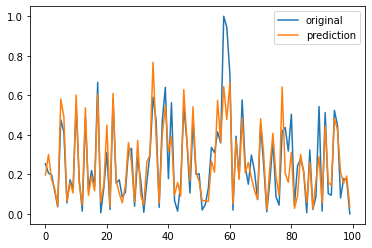

In [65]:
%matplotlib inline
plt.plot(label_np[:100])
plt.plot(predicted_data_np[:100])
plt.legend(['original', 'prediction'])
plt.show()